In [1]:
import dataset as dataset
import importlib
importlib.reload(dataset)
import utils as utils
import tensorflow as tf
import numpy as np
import model as model

# actual definition of tf models
class Unet(tf.keras.Model):

  def __init__(self, strName, intChans, strMode):
    super(Unet, self).__init__(name=strName)
    self.moduleIn = tf.keras.Sequential(
        [model.net_conv("conv_1", intChans[0], 3, 1, 1)], name="in_0")

    self.moduleMain = model.Unet("main", intChans, strMode)

    self.moduleOut = tf.keras.Sequential([
            model.net_conv("conv_1", intChans[0], 3, 2, 1),
            model.net_acti("acti_1"),
            model.net_conv("conv_2", 3, 3, 2, 1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1000, activation='relu'),
            tf.keras.layers.Dense(8, activation=None)], name="out_0")

  # end
  def call(self, tenIn):
    tenOut = self.moduleIn(tenIn)
    tenOut = self.moduleMain(tenOut)
    return self.moduleOut(tenOut)
  # end

class Mlpnet(tf.keras.Model):
    def __init__(self, strName, intChans, numIn):
        super(Mlpnet, self).__init__(name=strName)
        self.moduleIn = tf.keras.Sequential(
            [model.net_dense("dense_1", intChans[0], input_shape=(numIn * 3,))], name="in_0")
        self.moduleMain = model.Mlpnet("main", intChans)
        self.moduleOut = tf.keras.Sequential(
            [tf.keras.layers.Dense(num_classes, activation=None)], name="out_0")
    
    def call(self, tenIn):
        tenOut = self.moduleIn(tenIn)
        tenOut = self.moduleMain(tenOut)
        return self.moduleOut(tenOut)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [2]:
# tf.compat.v1.enable_eager_execution()
num_classes = 8

val_txt = './val_6.txt'
model_path = '/home/bmild/comp-color/data/ckpts_bw'
batch_size = 1
size = (128, 256)
num_bins = 128
architecture_depth = []
for i in range(4):
    architecture_depth.insert(0, np.power(2, (8 - i)))
mainmodel = Unet('main', architecture_depth, 'regular')
# mainmodel = Mlpnet('main', architecture_depth, num_bins)

next_batch_val = dataset.input_fn(
    dataset_name='blocky',
    train_txt_paths=[val_txt],
    eval_txt_paths=[val_txt],
    is_train=False,
    image_size=size,
    batch_size=batch_size)

inputs_val = next_batch_val['frames']
inputs_val.set_shape([batch_size, size[0], size[1], 20 * 3])
class_predict_val = mainmodel(inputs_val)
class_gt_val = next_batch_val['label']
class_gt_val = tf.cast(class_gt_val, tf.float32)
prediction = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction = tf.equal(prediction, ground_truth)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver_restore = tf.train.Saver([var for var in tf.trainable_variables()])
ckpt = tf.train.get_checkpoint_state(model_path)
restore_path = ckpt.model_checkpoint_path
saver_restore.restore(sess, restore_path)



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/bmild/comp-color/data/ckpts_bw/model.ckpt-499000


In [1]:
# tf.compat.v1.enable_eager_execution()
num_classes = 8

val_txt = './val_6.txt'
model_path = '/home/bmild/comp-color/data/ckpts_hist_2'
batch_size = 1
size = (128, 256)
num_bins = 128
architecture_depth = []
for i in range(4):
    architecture_depth.insert(0, np.power(2, (8 - i)))
# mainmodel = Unet('main', architecture_depth, 'regular')
mainmodel = Mlpnet('main', architecture_depth, num_bins)

inputs_val = next_batch_val['hist']
inputs_val.set_shape([batch_size, num_bins * 3])
class_predict_val = mainmodel(inputs_val)
class_gt_val = next_batch_val['label']
class_gt_val = tf.cast(class_gt_val, tf.float32)
prediction = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction = tf.equal(prediction, ground_truth)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver_restore = tf.train.Saver([var for var in tf.trainable_variables()])
ckpt = tf.train.get_checkpoint_state(model_path)
restore_path = ckpt.model_checkpoint_path
saver_restore.restore(sess, restore_path)

path = glob.glob('./casual/*.jpg')
filenames = np.random.permutation(path)

num_frames = 20
data_dict = dict()
for id, filei in enumerate(filenames[:num_frames]):
    image_i = np.array(Image.open(filei)) / 255.
    data_dict['frame_%d'%(id)] = tf.convert_to_tensor(image_i, dtype=tf.float32)
data_dict['label'] = 0

out_dict = data_process_hist_fn(data_dict, size=(128, 256), is_train=False)


SyntaxError: unexpected EOF while parsing (<ipython-input-1-6da602b88676>, line 2)

# Run on test frames

In [3]:
accuracy = np.zeros((num_classes,))
gt_class = np.zeros((num_classes,))
confusion = np.zeros((num_classes, num_classes))
num_eval = 300
predict_scores = np.zeros((num_eval, num_classes))
gt_scores = np.zeros((num_eval, num_classes))

fetch = [class_predict_val[0], ground_truth[0], class_gt_val[0]]
for step in range(num_eval):
    out_class_predict, out_ground_truth, out_ground_truth_vec = sess.run(fetch)
    predict_scores[step] = out_class_predict
    gt_scores[step] = out_ground_truth_vec

    pred_sort_ind = np.argsort(out_class_predict)
    gt_num_lables = int(out_ground_truth_vec.sum())
    for classi in range(num_classes):
        if out_ground_truth_vec[classi] >= 1.:
            if classi in pred_sort_ind[-gt_num_lables:]:
                accuracy[classi] += 1.
            for j in range(gt_num_lables):
                confusion[classi, pred_sort_ind[-j-1]] += 1
            
    gt_class[int(out_ground_truth)] += 1.
    if step % 50 == 0:
        print(out_class_predict, out_ground_truth)
print(accuracy)
print(gt_class)


[ 1.3306209 -2.7332418  8.289388  -6.989701  -8.203467  -5.638747
 -6.1839814 -2.6092305] 3
[ 1.3645444 -2.919883   8.908371  -7.6739287 -9.044081  -5.909023
 -6.927506  -2.6237254] 3
[ 1.4146475 -2.9519236  8.950554  -7.674094  -9.059409  -5.9803705
 -6.927108  -2.6431644] 1
[ 1.31935   -2.7831244  8.41627   -7.1283064 -8.356471  -5.69168
 -6.3141294 -2.5945475] 1
[ 1.3557591 -2.9086363  8.831478  -7.571404  -8.958138  -6.0183144
 -6.957951  -2.6137414] 0
[ 1.404066  -2.8929033  8.629849  -7.3094044 -8.635455  -5.8127475
 -6.4750304 -2.6661067] 3
[121.   8.  73.   0.   0.   0.   0.  44.]
[130.  48.  19.  51.  28.  12.  11.   1.]


In [37]:
confusion

array([[90., 33., 42., 19., 46., 54.,  8., 37.],
       [11., 41., 23.,  4.,  2., 32.,  0.,  3.],
       [35., 36., 52., 12., 19., 37.,  8., 17.],
       [23., 19., 31., 19., 10., 47.,  0.,  7.],
       [69., 20., 35., 18., 42., 33.,  8., 35.],
       [21., 42., 40., 22., 10., 74.,  0.,  5.],
       [25.,  5., 21.,  4., 17.,  8.,  6., 14.],
       [71., 22., 35.,  9., 33., 34.,  8., 37.]])

In [4]:
accuracy = np.zeros((num_classes,))
predict_scores_sort = np.argsort(predict_scores, 1)
gt_scores_sort = np.argsort(gt_scores, 1)

for i in range(predict_scores.shape[0]):
    pred_classi = np.argmax(predict_scores[i])
#     print(pred_classi, gt_scores[i][pred_classi], gt_scores[i][pred_classi]==1)
    if gt_scores[i][pred_classi] == 1:
        accuracy[pred_classi] += 1
        
print(accuracy)

[ 0.  0. 73.  0.  0.  0.  0.  0.]


In [82]:
print(accuracy / gt_scores.sum(0))

[0.34883721 0.42307692 0.30555556 0.01351351 0.14563107 0.23595506
 0.15384615 0.28888889]


In [45]:
gt_scores[0], np.where(gt_scores[0]==1)[0]

(array([1., 0., 0., 0., 1., 0., 0., 0.]), array([0, 4]))

In [47]:
confusion_gt = np.zeros((num_classes, num_classes))
for i in range(300):
    labels = np.where(gt_scores[i])[0]
    for x in (labels):
        for y in (labels):
            confusion_gt[x, y] += 1
            confusion_gt[y, x] += 1
print(confusion_gt)

[[258.   8.  76.   6. 138.  28.  24. 120.]
 [  8. 104.  30.  16.   0.  60.   0.  14.]
 [ 76.  30. 144.  38.  38.  40.  24.  42.]
 [  6.  16.  38. 148.  10.  74.   4.  16.]
 [138.   0.  38.  10. 206.  18.  36.  74.]
 [ 28.  60.  40.  74.  18. 178.   6.  24.]
 [ 24.   0.  24.   4.  36.   6.  78.  28.]
 [120.  14.  42.  16.  74.  24.  28. 180.]]


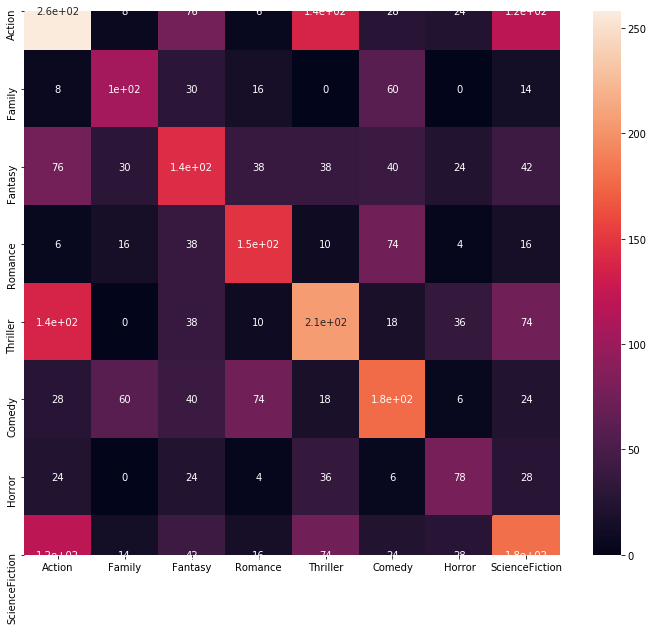

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Action
# Family
# Fantasy
# Romance
# Thriller
# Comedy
# Horror
# ScienceFiction

index = ['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction']
columns = ['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction'] 
cm_df = pd.DataFrame(confusion_gt, columns, index)
plt.figure(figsize=(12, 10))  
sns.heatmap(cm_df, annot=True)


In [ ]:
accuracy_global = 0
accuracy = np.zeros((num_classes,))
confusion = np.zeros((num_classes, num_classes))

for i in range(predict_scores.shape[0]):
    pred_classi = np.argsort(predict_scores[i])
    gt_num_lables = int(gt_scores[i].sum())
    labels = np.where(gt_scores[i])[0]
    print(gt_num_lables, labels)
    if gt_scores[i][pred_classi[-1]] == 1:
        accuracy[pred_classi[-1]] += 1
    
    for j in range(gt_num_lables):
        confusion[labels[j], pred_classi[-1-j]] += 1
#         if gt_scores[i][pred_classi[-(j+1)]] == 1:
#             accuracy_global += 1
        
print(confusion)

In [88]:
accuracy_global = 0
confuse_romance = np.zeros((num_classes,))
confusion = np.zeros((num_classes, num_classes))

for i in range(predict_scores.shape[0]):
    pred_classi = np.argmax(predict_scores[i])
    if gt_scores[i][6] == 1:
        confuse_romance[pred_classi] += 1
print(confuse_romance)

[12.  2. 13.  0.  9.  3.  0.  0.]


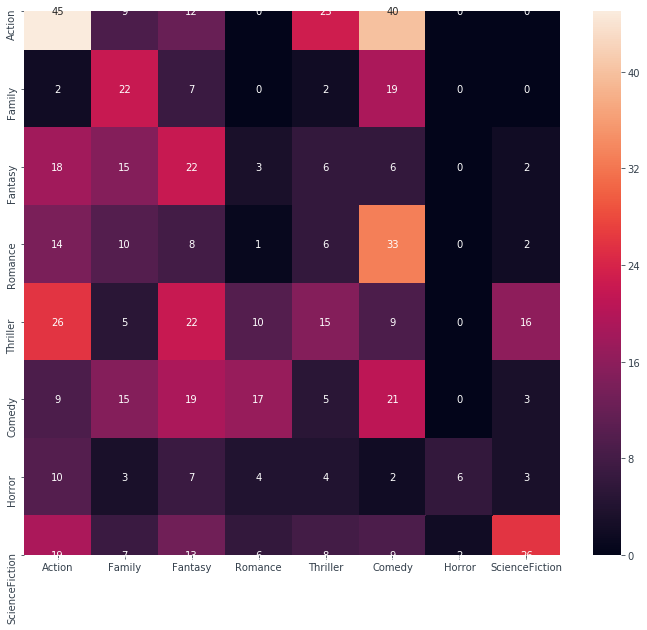

In [75]:
cm_df = pd.DataFrame(confusion, columns, index)
plt.figure(figsize=(12, 10))  
sns.heatmap(cm_df, annot=True)

In [81]:
accuracy = np.diag(confusion)
accuracy

array([45., 22., 22.,  1., 15., 21.,  6., 26.])

(0, 100)

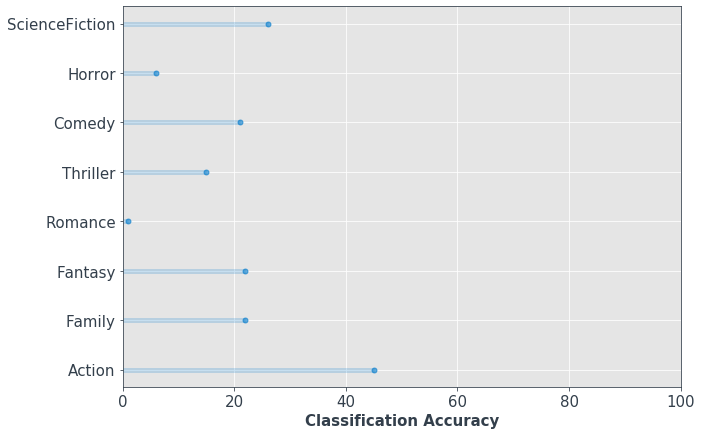

In [80]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

accuracy_pd = pd.Series(accuracy, 
                        index=['Action','Family','Fantasy','Romance','Thriller','Comedy','Horror','ScienceFiction'])
df = pd.DataFrame({'percentage' : accuracy_pd})
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(10, 7))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=accuracy_pd, color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(accuracy_pd, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Classification Accuracy', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# set axis
ax.tick_params(axis='both', which='major', labelsize=15)
plt.yticks(my_range, df.index)
plt.xlim((0,100))